In [1]:
from submissions.ab_submission.dataLoaders import imageDataLoader
from submissions.ab_submission.object_detector import ObjectDetector
from submissions.ab_submission import dataset

import importlib

importlib.reload(dataset)

<module 'submissions.ab_submission.dataset' from '/home/ali/git/follicles_detection/submissions/ab_submission/dataset.py'>

In [2]:
import glob
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
train_files = glob.glob("./data/train/*.jpg")
test_files = glob.glob("./data/test/*.jpg")
train_label = pd.read_csv("./data/train/labels.csv")
test_label = pd.read_csv("./data/test/labels.csv")

In [4]:
test_loader = imageDataLoader(test_files, test_label[["filename","xmin","xmax","ymin","ymax","label"]])
train_loader = imageDataLoader(train_files, train_label[["filename","xmin","xmax","ymin","ymax","label"]])
predict_loader = imageDataLoader(test_files, None)

In [5]:
import cv2
import numpy as np

In [6]:
import torch
from torch import nn
from torch.optim import Adam

In [7]:
# Dataset Generation
r = 10

X = []
Y = []
for x in train_loader.get_samples():
    new_shape = [int(x/r) for x in x[0].shape[0:2]]
    new_img = cv2.resize(x[0].astype(np.uint8), new_shape)

    label_matrix = np.zeros(x[0].shape[0:2])

    for bbox, label in zip(x[1], x[2]):
        if label > 0:
            label_matrix[bbox[2]:bbox[3], bbox[0]:bbox[1]] = 1
    label_matrix = label_matrix.astype("int8")
    new_label_matrix = cv2.resize(label_matrix.astype(np.uint8), new_shape)

    # Generating tensor
    new_img_tensor = torch.tensor(new_img, dtype=torch.float32)
    new_img_tensor = new_img_tensor.unsqueeze(2)
    new_img_tensor = torch.moveaxis(new_img_tensor, 2, 0)
    new_img_tensor = torch.moveaxis(new_img_tensor, 3, 1)

    new_label_matrix_tensor = torch.tensor(new_label_matrix, dtype=torch.float32)
    new_label_matrix_tensor = new_label_matrix_tensor.unsqueeze(dim=2).unsqueeze(dim=2)
    new_label_matrix_tensor = torch.moveaxis(new_label_matrix_tensor, 2, 0)
    new_label_matrix_tensor = torch.moveaxis(new_label_matrix_tensor, 3, 1)

    X.append(new_img_tensor)
    Y.append(new_label_matrix_tensor)

In [164]:
simple_network = nn.Sequential(*[
    nn.Conv2d(in_channels=3, kernel_size=(5,5), out_channels=10, padding="same"),
    nn.ReLU(),
    nn.Dropout2d(0.5),
    nn.Conv2d(in_channels=10, kernel_size=(3,3), out_channels=5, padding="same"),
    nn.Dropout2d(0.5),
    nn.Conv2d(in_channels=5, kernel_size=(1,1), out_channels=1, padding="same"),
    nn.Sigmoid()
])

simple_network = simple_network.to("cuda:0")

loss = nn.BCELoss()
optim = Adam(simple_network.parameters())

simple_network.train()

Sequential(
  (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Dropout2d(p=0.5, inplace=False)
  (3): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): Dropout2d(p=0.5, inplace=False)
  (5): Conv2d(5, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (6): Sigmoid()
)

In [176]:
from torch.nn.utils.rnn import pad_sequence

In [221]:
[x for x in X]

[tensor([[[[254., 254., 254.,  ..., 253., 254., 253.],
           [254., 254., 254.,  ..., 254., 253., 254.],
           [254., 254., 254.,  ..., 253., 253., 253.],
           ...,
           [252., 252., 252.,  ..., 252., 251., 252.],
           [251., 251., 253.,  ..., 252., 253., 251.],
           [252., 253., 252.,  ..., 253., 253., 252.]],
 
          [[255., 254., 254.,  ..., 254., 254., 253.],
           [254., 255., 254.,  ..., 254., 254., 254.],
           [254., 254., 254.,  ..., 253., 253., 254.],
           ...,
           [252., 252., 253.,  ..., 253., 252., 253.],
           [253., 252., 254.,  ..., 253., 254., 252.],
           [253., 254., 254.,  ..., 254., 253., 253.]],
 
          [[250., 252., 252.,  ..., 250., 252., 251.],
           [252., 250., 252.,  ..., 253., 249., 252.],
           [252., 252., 252.,  ..., 251., 251., 249.],
           ...,
           [250., 250., 248.,  ..., 248., 247., 248.],
           [250., 247., 249.,  ..., 248., 249., 247.],
           

In [173]:
n_epochs = 20

for i in range(n_epochs):
    losses = []
    if i > 0:
        print(f"Epoch {i} - mean loss : {mean_loss}")
    for x,y in zip(X,Y):

        x = x.to("cuda:0")
        y = y.to("cuda:0")

        y_hat = simple_network(x)
        y_hat = y_hat.flatten(start_dim=2,end_dim=3).squeeze(dim=1)
        y = y.flatten(start_dim=2, end_dim=3).squeeze(dim=1)
        
        n_loss = loss(y_hat, y)

        n_loss.backward()
        losses.append(n_loss.item())
        optim.step()

        optim.zero_grad
    mean_loss = np.array(losses).mean()

Epoch 1 - mean loss : 28.202766272143045
Epoch 2 - mean loss : 12.009280339397232
Epoch 3 - mean loss : 13.669619171783841
Epoch 4 - mean loss : 23.07825679614626
Epoch 5 - mean loss : 24.773734498769045
Epoch 6 - mean loss : 27.39247042248989
Epoch 7 - mean loss : 18.15771729242185
Epoch 8 - mean loss : 16.553015134971716
Epoch 9 - mean loss : 15.156939781816869
Epoch 10 - mean loss : 18.579571523157686
Epoch 11 - mean loss : 15.727089034586117
Epoch 12 - mean loss : 7.645652132044578
Epoch 13 - mean loss : 17.522007305945817
Epoch 14 - mean loss : 17.02852690759404
Epoch 15 - mean loss : 13.217810565284614
Epoch 16 - mean loss : 18.924426501167233
Epoch 17 - mean loss : 20.831229839602422
Epoch 18 - mean loss : 23.810703142449775
Epoch 19 - mean loss : 8.661169227341126


In [168]:
X_test = []
Y_test = []
for x in test_loader.get_samples():
    new_shape = [int(x/r) for x in x[0].shape[0:2]]
    new_img = cv2.resize(x[0].astype(np.uint8), new_shape)

    label_matrix = np.zeros(x[0].shape[0:2])

    for bbox, label in zip(x[1], x[2]):
        if label > 0:
            label_matrix[bbox[2]:bbox[3], bbox[0]:bbox[1]] = 1
    label_matrix = label_matrix.astype("int8")
    new_label_matrix = cv2.resize(label_matrix.astype(np.uint8), new_shape)

    # Generating tensor
    new_img_tensor = torch.tensor(new_img, dtype=torch.float32)
    new_img_tensor = new_img_tensor.unsqueeze(2)
    new_img_tensor = torch.moveaxis(new_img_tensor, 2, 0)
    new_img_tensor = torch.moveaxis(new_img_tensor, 3, 1)

    new_label_matrix_tensor = torch.tensor(new_label_matrix, dtype=torch.float32)
    new_label_matrix_tensor = new_label_matrix_tensor.unsqueeze(dim=2).unsqueeze(dim=2)
    new_label_matrix_tensor = torch.moveaxis(new_label_matrix_tensor, 2, 0)
    new_label_matrix_tensor = torch.moveaxis(new_label_matrix_tensor, 3, 1)

    X_test.append(new_img_tensor)
    Y_test.append(new_label_matrix_tensor)

In [161]:
with torch.no_grad():
    simple_network.eval()
    x_ = X_test[0].to("cuda:0")
    y_hat = simple_network(x_)

In [162]:
test = (y_hat >= 0.5).cpu().int()[0,0,:,:]

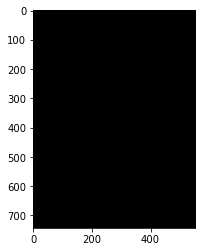

In [163]:
plt.imshow(1-test, cmap="gray")

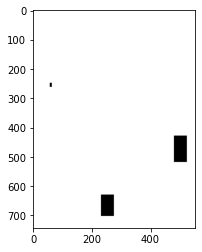

In [52]:
test2=Y_test[0].int()[0,0,:,:]
plt.imshow(1-test2, cmap="gray")